Read in packages

In [3]:
# %env SM_FRAMEWORK=tf.keras
import pandas as pd
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.lib.io import file_io
from tensorflow.python.keras.optimizer_v2.adam import Adam
import os
import segmentation_models as sm
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Input, AvgPool2D
from tensorflow.keras.models import Model
from keras_unet_collection import models
import tensorflow_addons as tfa
import logging
import albumentations as A
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from tensorflow import tensorflow.keras.mixed_precision.set_global_policy("mixed_float16")

Using logging since if the jupyter noteboock disconnects I want to keep track

In [3]:
# logger = logging.getLogger()
# fhandler = logging.FileHandler(filename='/att/nobackup/spotter5/cnn_mapping/nbac_training/test_log.log', mode='a')
# logger.addHandler(fhandler)
# # logging.basicConfig(filename='/att/nobackup/spotter5/cnn_mapping/nbac_training/test_log.log', level=logging.INFO)
# logging.warning('This is a warning message')
# import sys
# old_stdout = sys.stdout

# log_file = open("'/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/test_log.log","w")

# sys.stdout = log_file

# print("this will be written to message.log")

# sys.stdout = old_stdout

FileNotFoundError: [Errno 2] No such file or directory: "'/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/test_log.log"

In [ ]:
#Initialize GPUS with tensorflow

In [2]:
gpu_devices = tensorflow.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tensorflow.config.experimental.set_memory_growth(device, True)

Check GPUS are running

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
# watch -n0.5 nvidia-smi

from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

Thu May 26 16:12:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:61:00.0 Off |                    0 |
| N/A   38C    P0    43W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:62:00.0 Off |                    0 |
| N/A   

Read in the training files

In [2]:
#read in the trainiing and testing files and get lissts
train_files = pd.read_csv('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_training_files.csv')['Files'].tolist()
val_files = pd.read_csv('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_validation_files.csv')['Files'].tolist()
test_files = pd.read_csv('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_testing_files.csv')['Files'].tolist()


#functin to standardize all bands at once
from __future__ import division

#function to standardize
def normalize_meanstd(a, axis=None): 
    # axis param denotes axes along which mean & std reductions are to be performed
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std

#function to normalize
def normalize(a, axis=None): 
    # axis param denotes axes along which mean & std reductions are to be performed
    minv = np.min(a, axis=axis, keepdims=True)
    maxv = np.max(a, axis=axis, keepdims=True)
    return (a - minv) / (maxv - minv)


#function to get files from storage bucket
def get_files(bucket_path):

  """argument is the path to where the numpy
  save files are located, return a list of filenames
  """
  all = []

  #list of files
  files = os.listdir(bucket_path)

  #get list of filenames we will use, notte I remove images that don't have a target due to clouds
  file_names = []
  for f in files:
    if f.endswith('.npy'):


      all.append(os.path.join(bucket_path, f))
  return(all)
  

#get all the pathways
training_data_names = get_files('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_training_data')
training_label_names = get_files('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_training_labels')
validation_data_names = get_files('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_validation_data')
validation_label_names = get_files('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_validation_labels')
testing_data_names = get_files('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_testing_data')
testing_label_names = get_files('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/median_testing_labels')


print(len(training_data_names))
print(len(validation_data_names))
print(len(testing_data_names))

# t = training_data_names[0].split('/')[:-1]
# t2 = training_data_names[0].split('/')[-1]
# t = '/'.join(t)
# print(t)
# print(t2)


9514
1081
1082


Lets do 2x augmentation and save all training data to a new folder

In [ ]:
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.7),
    A.ShiftScaleRotate(p=0.7),
    A.VerticalFlip(p=0.7)
])


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def my_aug(x_path, y_path, x_out_path, y_out_path, n_aug):
    

    '''inputs are path to x directory, path to y directory, x_output path, y_output path 
    and number of times to augment'''
    
    #make out paths
    if not os.path.isdir(x_out_path):
        os.makedirs(x_out_path)
        
    if not os.path.isdir(y_out_path):
        os.makedirs(y_out_path)
    
    
    #loop through files
    for f in os.listdir(x_path):
        
        if f.endswith('.npy'):
            print(f)
            x = np.load(os.path.join(x_path, f))
            y = np.load(os.path.join(y_path, f))

            np.save(os.path.join(x_out_path, f), x)
            np.save(os.path.join(y_out_path, f), y)
            
            x= x.astype(float)
            x[x == 0] = -999

            x[np.isnan(x)] = -999

            x[x == -999] = np.nan

            in_shape = x.shape

            #turn to dataframe to normalize
            x = x.reshape(x.shape[0] * x.shape[1], x.shape[2])

            #normalize 0 to 1
            x = scaler.fit_transform(x)

            #convert back to iriginall shape
            x = x.reshape(in_shape)

            #replace nan with -1
            x[np.isnan(x)] = -1
            
                       
            y = y.astype(int)

            y[y < 0] = 0
            y[y >1] = 0
            y[~np.isin(y, [0,1])] = 0
          
            y[np.isnan(y)] = 0
            y = y.astype(int)
           
            
            
#             x[x == 0] = -999
#             x[np.isnan(x)] = -999

#             y = y.astype(int)

#             y[y < 0] = 0
#             y[y >1] = 0
#             y[~np.isin(y, [0,1])] = 0

#             y[np.isnan(y)] = 0

            unique_val = np.unique(y)

            if (np.all(x == -1) == False) and (len(unique_val == 2)):
            
#             if len(unique_val == 2):


                #augment two times and keep original image
                for i in range(n_aug):

                    transformed = transform(image=x, mask=y)
                    my_im = transformed['image']
                    lb = transformed['mask']


#                     my_im[my_im == 0] = -999
#                     my_im[np.isnan(my_im)] = -999

#                     lb = lb.astype(int)

#                     lb[lb < 0] = 0
#                     lb[lb >1] = 0
#                     lb[~np.isin(lb, [0,1])] = 0

#                     lb[np.isnan(lb)] = 0

                    unique_val = np.unique(lb)

                    if (np.all(my_im == -1) == False) and (len(unique_val == 2)):
    #                 print(np.nanmax(transformed))
    #                 print(np.nanmax(lb))


                        i_out = str(i) + '_' + f
                        np.save(os.path.join(x_out_path, i_out), my_im)
                        np.save(os.path.join(y_out_path, i_out), lb)

#run augmentation
my_aug('/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_1985_sent_harm_0_training_data', 
      '/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_1985_sent_harm_0_training_labels',
      '/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_1985_sent_harm_0_training_data_aug', 
      '/adapt/nobackup/people/spotter5/cnn_mapping/nbac_training/nbac_1985_sent_harm_0_training_labels_aug',
      2)
        
        
        

25_7272.npy
22_99.npy
20_1759.npy
29_7672.npy
24_5404.npy
7_6307.npy
4_10016.npy
5_678.npy
908_6777.npy
34_5370.npy
1167_8017.npy
9_5315.npy
10_3845.npy
1027_4857.npy
158_9790.npy
276_816.npy
71_1589.npy
4_7868.npy
36_1796.npy
18_1237.npy
10_2113.npy
44_6817.npy
1404_7577.npy
10_1696.npy
652_868.npy
1_4226.npy
7_2247.npy
10_10479.npy
15_2875.npy
1042_4857.npy
11_1895.npy
50_2714.npy
3_10096.npy
5_1693.npy
90_2990.npy
4_3157.npy
42_9279.npy
39_798.npy
96_215.npy
431_3223.npy
6_6408.npy
26_7636.npy
7_4399.npy
5_5008.npy
11_1399.npy
381_7725.npy
5_11004.npy
24_3484.npy
24_7137.npy
100_4525.npy
362_978.npy
10_3671.npy
99_8727.npy
7_6420.npy
120_1231.npy
73_1259.npy
2_9756.npy
7_7322.npy
214_967.npy
562_9280.npy
2_2856.npy
409_10833.npy
43_3511.npy
26_561.npy
13_1603.npy
36_53.npy
42_55.npy
2_1178.npy
609_3246.npy
5_3734.npy
7_1129.npy
516_10941.npy
212_7824.npy
25_7796.npy
145_10878.npy
1266_7577.npy
12_4483.npy
6_3634.npy
29_9736.npy
777_10941.npy
35_694.npy
84_6387.npy
826_4857.npy
291_3

Now lets read in the aug file names

In [5]:
#read in the trainiing and testing files and get lissts
train_files = pd.read_csv('/att/nobackup/spotter5/cnn_mapping/nbac_training/training_files.csv')['Files'].tolist()
val_files = pd.read_csv('/att/nobackup/spotter5/cnn_mapping/nbac_training//validation_files.csv')['Files'].tolist()
test_files = pd.read_csv('/att/nobackup/spotter5/cnn_mapping/nbac_training//testing_files.csv')['Files'].tolist()


#functin to standardize all bands at once
from __future__ import division

#function to standardize
def normalize_meanstd(a, axis=None): 
    # axis param denotes axes along which mean & std reductions are to be performed
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std

#function to normalize
def normalize(a, axis=None): 
    # axis param denotes axes along which mean & std reductions are to be performed
    minv = np.min(a, axis=axis, keepdims=True)
    maxv = np.max(a, axis=axis, keepdims=True)
    return (a - minv) / (maxv - minv)


#function to get files from storage bucket
def get_files(bucket_path):

  """argument is the path to where the numpy
  save files are located, return a list of filenames
  """
  all = []

  #list of files
  files = os.listdir(bucket_path)

  #get list of filenames we will use, notte I remove images that don't have a target due to clouds
  file_names = []
  for f in files:
    if f.endswith('.npy'):


      all.append(os.path.join(bucket_path, f))
  return(all)
  

#get all the pathways
training_data_names = get_files('/att/nobackup/spotter5/cnn_mapping/nbac_training/ak_training_data_aug')
training_label_names = get_files('/att/nobackup/spotter5/cnn_mapping/nbac_training/ak_training_labels_aug')
validation_data_names = get_files('/att/nobackup/spotter5/cnn_mapping/nbac_training/ak_validation_data')
validation_label_names = get_files('/att/nobackup/spotter5/cnn_mapping/nbac_training/ak_validation_labels')
testing_data_names = get_files('/att/nobackup/spotter5/cnn_mapping/nbac_training/ak_testing_data')
testing_label_names = get_files('/att/nobackup/spotter5/cnn_mapping/nbac_training/ak_testing_labels')


print(len(training_data_names))
print(len(validation_data_names))
print(len(testing_data_names))


16667
695
695


In [6]:
#for min max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


#for augmentation

transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=1.0),
    A.ShiftScaleRotate(p=1.0),
    A.VerticalFlip(p=1.0)
])


Set up image generator for augmentation

In [108]:
# #for min max scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()


# #for augmentation

# transform = A.Compose([
#     A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=1.0),
#     A.ShiftScaleRotate(p=1.0),
#     A.VerticalFlip(p=1.0)
# ])

# class img_gen_aug(tensorflow.keras.utils.Sequence):

#     """Helper to iterate over the data (as Numpy arrays).
#     Inputs are batch size, the image size, the input paths (x) and target paths (y)
#     """

#     #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
#     def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
#         self.batch_size = batch_size * 3
#         self.img_size = img_size
#         self.input_img_paths = input_img_paths
#         self.target_img_paths = target_img_paths

#     #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
#     def __len__(self):
#         return len(self.target_img_paths * 3) // self.batch_size #we need to multiply this times three because I am augmenting two images
        
#     def __getitem__(self, idx):
#         """Returns tuple (input, target) correspond to batch #idx."""
#         i = idx * self.batch_size  
#         batch_input_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
#         batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
#         x_stack = np.zeros((self.batch_size,) + self.img_size + (9,), dtype="float32") #create matrix of zeros which will have the dimension (batch_size, height, wideth, n_bands), 8 is the n_bands
#         #do tthe same thing for y
#         y_stack = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        
#         n = 0
       
       
#         #start populating x by enumerating over the input img paths
#         for path in batch_input_img_paths:
                
#                 #get the base path for the training_data
#                 batch_input_img_paths2 = path.split('/')[:-1]
#                 batch_input_img_paths2 = '/'.join(batch_input_img_paths2)
                
#                 #get the file name
#                 f = path.split('/')[-1]
                
#                 #get the base path for the labels
#                 batch_target_img_paths2 = batch_target_img_paths[0].split('/')[:-1]
#                 batch_target_img_paths2 = '/'.join(batch_target_img_paths2)
                

#                 #load x and y
#                 x = np.round(np.load(os.path.join(batch_input_img_paths2, f)), 3)
#                 y = np.load(os.path.join(batch_target_img_paths2, f))

#                 #apply double augmentation
#                 for i in range(2):

#                     #do the augmentation
#                     transformed = transform(image=x, mask=y)
#                     my_im = transformed['image']
#                     lb = transformed['mask']

#                     my_im[my_im == 0] = -999

#                     my_im[np.isnan(my_im)] = -999

#                     my_im[my_im== -999] = np.nan

#                     in_shape = my_im.shape

#                     #turn to dataframe to normalize
#                     my_im = my_im.reshape(my_im.shape[0] * my_im.shape[1], my_im.shape[2])

#                     #normalize 0 to 1
#                     my_im = scaler.fit_transform(my_im)

#                     #convert back to iriginall shape
#                     my_im = my_im.reshape(in_shape)

#                     #replace nan with -1
#                     my_im[np.isnan(my_im)] = -1

#                     #populate x
#                     x_stack[n] = my_im#[:, :, 4:] index number is included, 

#                     #do the same for y
#                     lb = lb.astype(int)

#                     lb[lb < 0] = 0
#                     lb[lb >1] = 0
#                     lb[~np.isin(lb, [0,1])] = 0

#                     lb[np.isnan(lb)] = 0
#                     lb = lb.astype(int)

# #                     print(lb.shape)

#                     # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
#                     y_stack[n] = np.expand_dims(lb, 2) 

#                     n+=1



#                 #now add back in the original data too

#                 x[x == 0] = -999

#                 x[np.isnan(x)] = -999

#                 x[x== -999] = np.nan

#                 in_shape = x.shape

#                 #turn to dataframe to normalize
#                 x = x.reshape(x.shape[0] * x.shape[1], x.shape[2])

#                 #normalize 0 to 1
#                 x = scaler.fit_transform(x)

#                 #convert back to iriginall shape
#                 x = x.reshape(in_shape)

#                 #replace nan with -1
#                 x[np.isnan(x)] = -1

#                 #populate x
#                 x_stack[n] = x#[:, :, 4:] index number is included, 

#                 #do the same for y
#                 y = y.astype(int)

#                 y[y < 0] = 0
#                 y[y >1] = 0
#                 y[~np.isin(y, [0,1])] = 0

#                 y[np.isnan(y)] = 0
#                 y = y.astype(int)

#                 y_stack[n] = np.expand_dims(y, 2) 
#                 n+-1            

#         return x_stack, y_stack

Make generator when I don't want to use augmentation

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
class img_gen(tensorflow.keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays).
    Inputs are batch size, the image size, the input paths (x) and target paths (y)
    """

    #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
        x = np.zeros((self.batch_size,) + self.img_size + (9,), dtype="float32") #create matrix of zeros which will have the dimension (batch_size, height, wideth, n_bands), 8 is the n_bands
        
        #start populating x by enumerating over the input img paths
        for j, path in enumerate(batch_input_img_paths):
      
            #load image
            img =  np.round(np.load(path), 3)
           
            img[img == 0] = -999

            img[np.isnan(img)] = -999

            img[img == -999] = np.nan

            in_shape = img.shape

            #turn to dataframe to normalize
            img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

            #normalize 0 to 1
            img = scaler.fit_transform(img)

            #convert back to iriginall shape
            img = img.reshape(in_shape)

            #replace nan with -1
            img[np.isnan(img)] = -1

            #apply standardization
            # img = normalize(img, axis=(0,1))

            #populate x
            x[j] = img#[:, :, 4:] index number is not included, 
            
        #do tthe same thing for y
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        
        for j, path in enumerate(batch_target_img_paths):
                                   
            #load image
            img =  np.round(np.load(path), 3)
               
            img = img.astype(int)

            img[img < 0] = 0
            img[img >1] = 0
            img[~np.isin(img, [0,1])] = 0
          
            img[np.isnan(img)] = 0
            img = img.astype(int)
           
            # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
            y[j] = np.expand_dims(img, 2) 
         

            #Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1

        return x, y

Read in the images based on the generator

In [8]:
#batch size and img size
BATCH_SIZE = 15
GPUS = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
strategy = tensorflow.distribute.MirroredStrategy() #can add GPUS here to select specific ones
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

batch_size = BATCH_SIZE * strategy.num_replicas_in_sync



#image size
img_size = (256, 256)

#number of classes to predict
num_classes = 1


#get images
train_gen = img_gen(batch_size, img_size, training_data_names, training_label_names)
val_gen = img_gen(batch_size, img_size, validation_data_names, validation_label_names)
test_gen = img_gen(batch_size, img_size, testing_data_names, testing_label_names)
test_gen_t = img_gen(batch_size, img_size, testing_data_names, testing_label_names)

Number of devices: 4


Unet model

Unet ++

Segmentation moodels Unet

In [26]:
model_unet_from_scratch = models.unet_2d((256, 256, 9), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=num_classes, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=True, unpool=True, 
                           backbone=None, weights=None, 
                           freeze_backbone=False, freeze_batch_norm=False, 
                           name='unet')

In [5]:
help(models.unet_3plus_2d)

Help on function unet_3plus_2d in module keras_unet_collection._model_unet_3plus_2d:

unet_3plus_2d(input_size, n_labels, filter_num_down, filter_num_skip='auto', filter_num_aggregate='auto', stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid', batch_norm=False, pool=True, unpool=True, deep_supervision=False, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet3plus')
    UNET 3+ with an optional ImageNet-trained backbone.
    
    unet_3plus_2d(input_size, n_labels, filter_num_down, filter_num_skip='auto', filter_num_aggregate='auto', 
                  stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                  batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                  backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet3plus')
                  
    ----------
    Huang, H., Lin, L., Tong, R., Hu, H., Zhang, Q., 

In [9]:
# Free up RAM in case the model definition cells were run multiple times
tensorflow.keras.backend.clear_session()
# model = get_model(img_size, num_classes)
# model.summary()

Train model across multiple GPUS

In [ ]:
%load_ext tensorboard
# #setting learninig rate
# optimizer = tf.keras.optimizers.RMSprop(0.001) #this is 1e-3, default or 'rmsprop'

optimizer = tensorflow.keras.optimizers.Adam() #this is 1e-3, default or 'rmsprop'
LR = 0.0005
    
# optimizer.learning_rate.assign(1e-04) 
# optimizer = tf.keras.optimizers.Adam() 

# optimizer = tf.keras.optimizers.RMSprop(0.001)
loss=tensorflow.keras.losses.BinaryCrossentropy(
    from_logits=False)

# loss=tf.keras.losses.CategoricalCrossentropy(
#     from_logits=False)

#set loss function, optmizer and metric
# model.compile(loss="binary_crossentropy",
#               optimizer='rmsprop',
#               metrics=["accuracy"])
# early_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# callbacks = [
#     tensorflow.keras.callbacks.ModelCheckpoint("/att/nobackup/spotter5/cnn_mapping/nbac_training/all_36b_no_aug_adam_5_band.h5",
#                                     save_best_only=True)
# ]


callbacks = [tensorflow.keras.callbacks.ModelCheckpoint(
    filepath="/att/nobackup/spotter5/cnn_mapping/nbac_training/15b_adam_dice_9bands_aug_real_100.h5",
#     verbose=1,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_mean_iou',
    mode = 'max'),
    tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=10)]
    
tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', mode = 'min', patience = 10, min_delta=0.001, min_LR = LR/25, verbose = 1)

# callbacks = [tensorflow.keras.callbacks.ModelCheckpoint(
#     filepath="/att/nobackup/spotter5/cnn_mapping/nbac_training/test.h5",
# #     verbose=1,
#     save_weights_only=True,
#     save_best_only=True,
#     monitor='val_mean_iou',
#     mode = 'max'),
#     tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=10)]


# Open a strategy scope.
with strategy.scope():
    
    model_unet_from_scratch = models.unet_2d((256, 256, 9), filter_num=[64, 128, 256, 512, 1024], 
               n_labels=num_classes, 
               stack_num_down=2, stack_num_up=2, 
               activation='ReLU', 
               output_activation='Sigmoid', 
               batch_norm=True, pool=False, unpool=False, 
               backbone='EfficientNetB7', weights=None, 
               freeze_backbone=False, freeze_batch_norm=False, 
               name='unet')

#     model_unet_from_scratch = models.unet_2d((256, 256, 9), filter_num=[64, 128, 256, 512, 1024], 
#                        n_labels=num_classes, 
#                        stack_num_down=2, stack_num_up=2, 
#                        activation='ReLU', 
#                        output_activation='Sigmoid', 
#                        batch_norm=True, pool=False, unpool=False, 
#                        backbone='ResNet50', weights='imagenet', 
#                        freeze_backbone=True, freeze_batch_norm=True, 
#                        name='unet')

    model_unet_from_scratch.compile(loss='binary_crossentropy',
                                    optimizer='adam',
                                    metrics=[sm.metrics.Precision(threshold=0.5),
                                      sm.metrics.Recall(threshold=0.5),
                                      sm.metrics.FScore(threshold=0.5), 
                                      sm.metrics.IOUScore(threshold=0.5)])

#fit the model
history = model_unet_from_scratch.fit(
    train_gen,
    epochs= 100,
    callbacks = callbacks,
    validation_data=val_gen) 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs/fit

model_unet_from_scratch.save("/att/nobackup/spotter5/cnn_mapping/nbac_training/15b_adam_dice_9bands_aug_real_backup_100.h5")

history_dict = history.history

#save output
result = pd.DataFrame({'Precision': history_dict["precision"],
                       'Val_Precision': history_dict['val_precision'],
                       'Recall': history_dict["recall"],
                       'Val_Recall': history_dict['recall'],
                       'F1': history_dict["f1-score"],
                       'Val_F1': history_dict['val_f1-score'],
                       'IOU': history_dict["iou_score"],
                       'Val_IOU': history_dict['val_iou_score'],
                       'Loss': history_dict['loss'],
                       'Val_Loss': history_dict['val_loss']})
result.to_csv("/att/nobackup/spotter5/cnn_mapping/nbac_training/all_15b_no_aug_adam_9_band_aug_real_100.csv")


#save model
# np.save(file_io.FileIO('gs://smp-scratch/base_unet++_1000_150_8_adam_9band_2_class.npy', 'w'), history.history)


Epoch 1/100
277/277 [==============================] - 2645s 9s/step - loss: 0.2235 - precision: 0.7769 - recall: 0.7591 - f1-score: 0.7494 - iou_score: 0.6240 - val_loss: 1.2855 - val_precision: 1.0000 - val_recall: 6.0645e-11 - val_f1-score: 6.0645e-11 - val_iou_score: 6.0645e-11
Epoch 2/100
277/277 [==============================] - 2295s 8s/step - loss: 0.1437 - precision: 0.8559 - recall: 0.8788 - f1-score: 0.8610 - iou_score: 0.7625 - val_loss: 0.8075 - val_precision: 0.8265 - val_recall: 0.0030 - val_f1-score: 0.0059 - val_iou_score: 0.0030
Epoch 3/100
277/277 [==============================] - 2138s 8s/step - loss: 0.1298 - precision: 0.8682 - recall: 0.8893 - f1-score: 0.8738 - iou_score: 0.7820 - val_loss: 0.1244 - val_precision: 0.8661 - val_recall: 0.9045 - val_f1-score: 0.8805 - val_iou_score: 0.7932
Epoch 4/100
277/277 [==============================] - 2202s 8s/step - loss: 0.1229 - precision: 0.8771 - recall: 0.8945 - f1-score: 0.8814 - iou_score: 0.7937 - val_loss: 0.1

In [ ]:
# print("Evaluate on test data")
# results_f = history.evaluate(test_gen, batch_size=128)
# print("test loss, test acc:", results)optimizers

In [ ]:
print(history_dict.keys())


Get final prediction


In [2]:
#load model
# weights = model.load_weights("/att/nobackup/spotter5/cnn_mapping/nbac_training/base_unet++_1000_150_8_adam_9band_2class.h5") 
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_collection2_256.csv")
df['Epoch'] = df.index + 1
print(df.tail)

<bound method NDFrame.tail of     Unnamed: 0  Precision  Val_Precision    Recall  Val_Recall        F1  \
0            0   0.799293       0.239941  0.839801    0.839801  0.803727   
1            1   0.887884       0.397671  0.885295    0.885295  0.882444   
2            2   0.901532       0.896588  0.897521    0.897521  0.896867   
3            3   0.908859       0.897706  0.909611    0.909611  0.907339   
4            4   0.911866       0.913206  0.912754    0.912754  0.910499   
5            5   0.914827       0.920760  0.916800    0.916800  0.914197   
6            6   0.916919       0.913240  0.919222    0.919222  0.916464   
7            7   0.918667       0.931086  0.919862    0.919862  0.917929   
8            8   0.921962       0.928131  0.923009    0.923009  0.921262   
9            9   0.921932       0.884096  0.923217    0.923217  0.921362   
10          10   0.924321       0.916886  0.926711    0.926711  0.924443   
11          11   0.924825       0.941981  0.926989    0.92

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

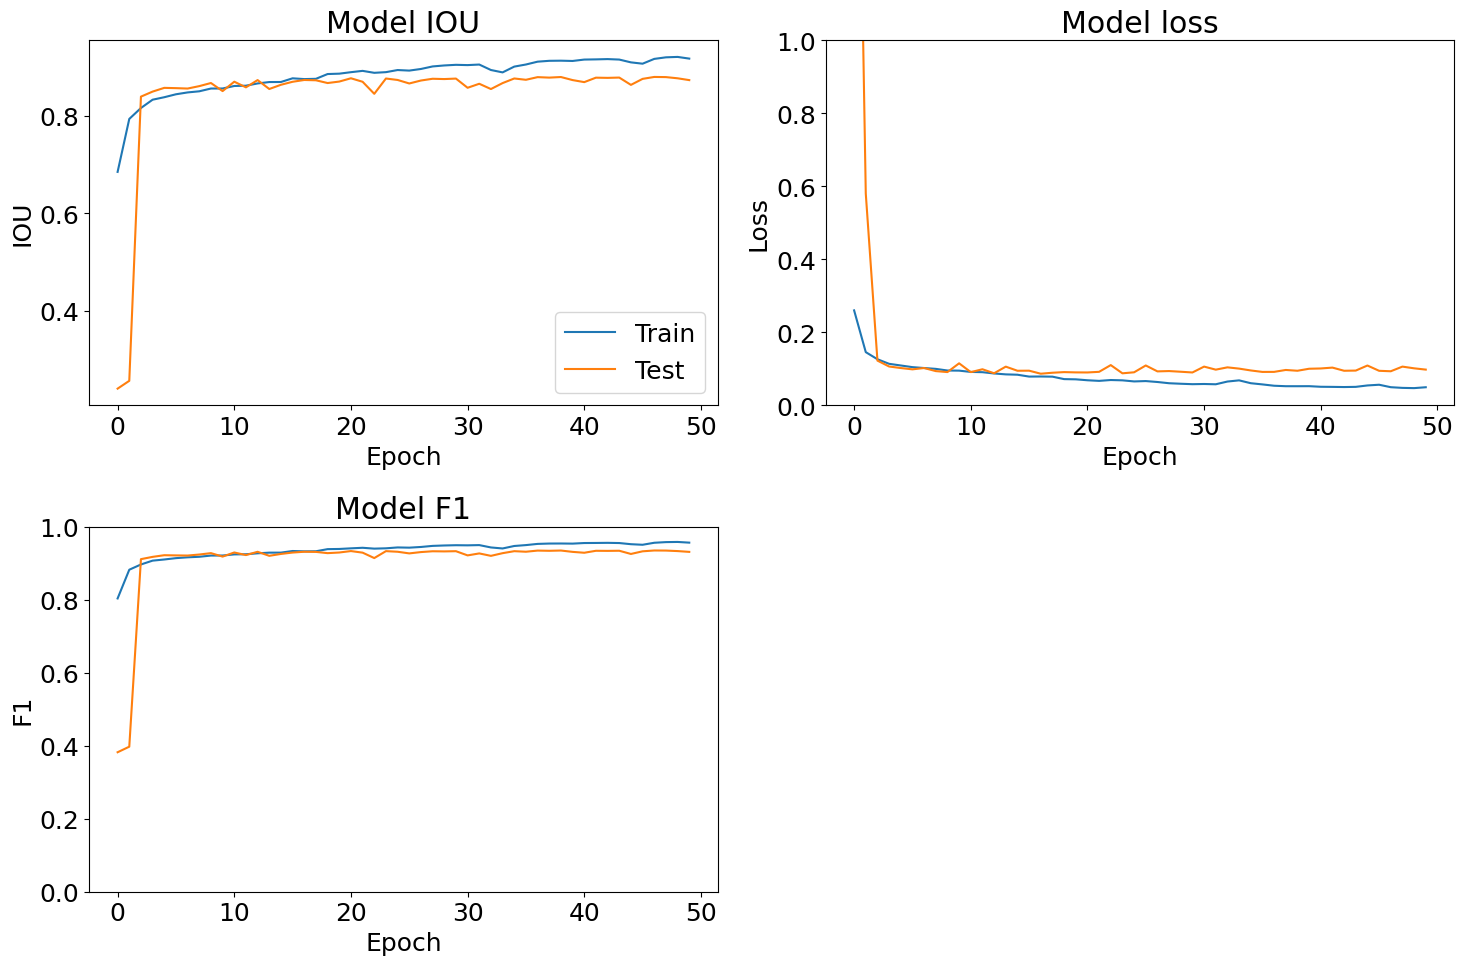

In [3]:
import matplotlib

font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
#plot the curves
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(df['IOU'])
plt.plot(df['Val_IOU'])
plt.title("Model IOU")
plt.ylabel('IOU')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.xlim(40,70)
plt.legend(['Train', 'Test'], loc='lower right')


# Plot training & validation loss values
plt.subplot(222)
plt.plot(df['Loss'])
plt.plot(df['Val_Loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(223)
plt.plot(df['F1'])
plt.plot(df['Val_F1'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.ylim(0, 1)


plt.tight_layout()
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plt.subplot(122)
# plt.plot(df['Loss'])
# plt.plot(df['Val_Loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.ylim(0, 1)
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [34]:
model0 = tensorflow.keras.models.load_model("/att/nobackup/spotter5/cnn_mapping/nbac_training/15b_adam_dice_9bands_aug_backup_150.h5", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5)})

# model1 = tensorflow.keras.models.load_model("/att/nobackup/spotter5/cnn_mapping/nbac_training/32b_adam_dice_9bands_backup.h5", 
#                                            custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
#                                                            'recall':sm.metrics.Recall(threshold = 0.5),
#                                                             'f1-score': sm.metrics.FScore(threshold=0.5),
#                                                              'iou_score': sm.metrics.IOUScore(threshold=0.5)})



In [38]:
#evaluate on validation set
print(model1.metrics_names)
# eval_res0 = model0.evaluate_generator(test_gen_t, 200)
eval_res0 = model0.evaluate_generator(test_gen, 200)

['loss', 'precision', 'recall', 'f1-score', 'iou_score']


/tmp/ipykernel_144352/2624546651.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  eval_res0 = model0.evaluate_generator(test_gen, 200)


In [39]:
eval_res0
# eval_res1

[0.2114846408367157,
 0.8903652429580688,
 0.908935010433197,
 0.8992950916290283,
 0.8180709481239319]

In [26]:
model0.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['iou_score'])


model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['iou_score'])


In [27]:
predictions0 = model1.predict_generator(test_gen, 200)
predictions1 = model1.predict_generator(test_gen, 200)

/tmp/ipykernel_90225/3035184490.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model1.predict_generator(test_gen, 200)


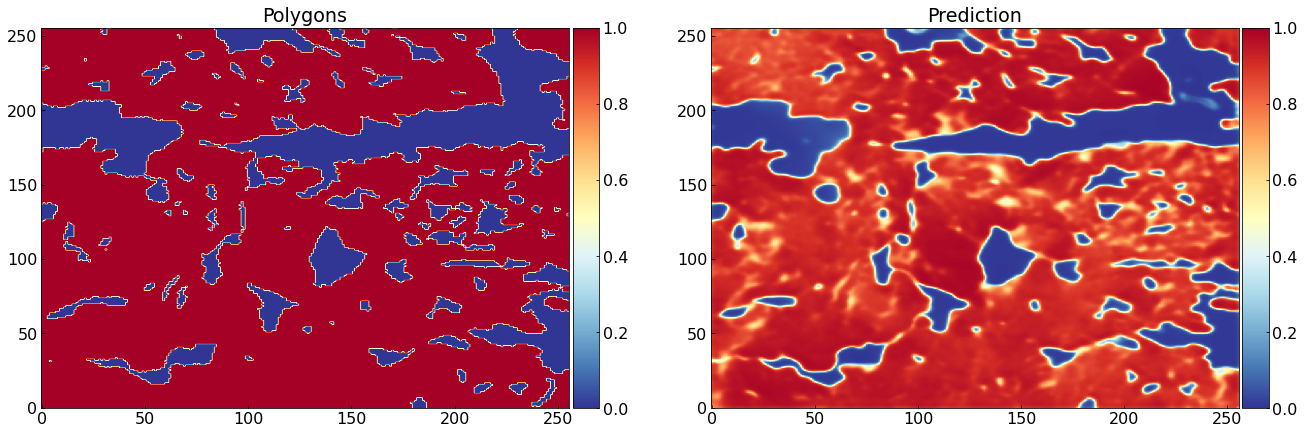

In [28]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

#get the ground truth
n = 111
truth = np.load(testing_label_names[n])
# plt.imshow(truth)

pred0 = predictions[n][:, :, 0]
pred01 = predictions[n][:, :, 0]

# plt.imshow(pred)

fig, ax = plt.subplots(ncols = 2, nrows = 1,figsize = (22, 7))
                      
#plot 1
im = ax[0,0].imshow(truth, origin = 'lower', cmap = 'RdYlBu_r', aspect= 'auto', vmin=0, vmax=1)
ax[0,0].title.set_text('Polygons')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

#plot2
im2 = ax[0,1].imshow(pred0, origin = 'lower', cmap = 'RdYlBu_r', aspect= 'auto',vmin=0, vmax=1)
ax[0,1].title.set_text('5 Band Prediction')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

#plot2
im2 = ax[1,0].imshow(pred, origin = 'lower', cmap = 'RdYlBu_r', aspect= 'auto',vmin=0, vmax=1)
ax[1,0].title.set_text('9 Band Prediction')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


In [15]:
print('t')

t
